This is an illustrative example of a Pairs Trading involving Coca-Cola (KO) and PepsiCo (PEP), despite being fundamentaly different companies, for example, KO has half the sales of PEP but has a higher Net Income however they both manufacture, distribute and sell soft beverages.

But the market already knows past information if any new information is released, specially if affects both companies like for example new regulations affecting the beverage market, its expected that it will affect both companies in the same way therefore the price of each should move in the same direction.

This strategy falls under the expectation that when prices depart from their historic equilibrium (quantified here as rolling correlation), the company that valued less in the last week will catchup during the trade session, being the positions open at open price (slippage & transaction costs can be factored in but aren't accounted for) and sold at close

In [3]:
# For yahoo finance
import io
import re
import requests

# The usual suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yahooFinance

# Fancy graphics
# plt.style.use('seaborn')

# Getting Yahoo finance data
def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0, error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

# Assets under consideration
tickers = ['PEP','KO']

# data = None
# while data is None:
#     try:
#         data = getdata(tickers,'946685000','1687427200','1d')
#     except:
#          pass
    
# Get data from Yahoo Finance
KO = yahooFinance.Ticker("KO").history(start='2000-01-01', end='2023-11-11')
PEP = yahooFinance.Ticker("PEP").history(start='2000-01-01', end='2023-11-11')

# KO = data['KO']
# PEP = data['PEP']
KO

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,14.968977,14.968977,14.259241,14.549587,10997000,0.0,0.0
2000-01-04 00:00:00-05:00,14.549596,14.662509,14.356031,14.565726,7308000,0.0,0.0
2000-01-05 00:00:00-05:00,14.565713,14.823798,14.468931,14.694756,9457400,0.0,0.0
2000-01-06 00:00:00-05:00,14.694761,14.888326,14.597979,14.710892,7129200,0.0,0.0
2000-01-07 00:00:00-05:00,14.936716,15.678713,14.936716,15.678713,11474000,0.0,0.0
...,...,...,...,...,...,...,...
2023-11-06 00:00:00-05:00,56.331453,56.827503,56.291772,56.519955,12673200,0.0,0.0
2023-11-07 00:00:00-05:00,56.470346,56.946558,56.281848,56.728294,10449300,0.0,0.0
2023-11-08 00:00:00-05:00,56.867190,57.016007,56.470349,56.639008,13744000,0.0,0.0


In [4]:
#tc = -0.0005 # Transaction costs

pairs = pd.DataFrame({'TPEP':PEP['Close'].shift(1)/PEP['Close'].shift(2)-1,
                      'TKO':KO['Close'].shift(1)/KO['Close'].shift(2)-1})

# Criteria to select which asset we're going to buy, in this case, the one that had the lowest return yesterday
pairs['Target'] = pairs.min(axis=1)

# Signal that triggers the purchase of the asset
pairs['Correlation'] = ((PEP['Close'].shift(1)/PEP['Close'].shift(20)-1).rolling(window=9)
                        .corr((KO['Close'].shift(1)/KO['Close'].shift(20)-1)))

Signal = pairs['Correlation'] < 0.9

# We're holding positions that weren't profitable yesterday
HoldingYesterdayPosition = ((pairs['Target'].shift(1).isin(pairs['TPEP']) &
                             (PEP['Close'].shift(1)/PEP['Open'].shift(1)-1 < 0)) |
                            (pairs['Target'].shift(1).isin(pairs['TKO']) &
                             (KO['Close'].shift(1)/KO['Open'].shift(1)-1 < 0))) # if tc, add here

# Since we aren't using leverage, we can't enter on a new position if
# we entered on a position yesterday (and if it wasn't profitable)
NoMoney = Signal.shift(1) & HoldingYesterdayPosition

pairs['PEP'] = np.where(NoMoney,
                        np.nan,
                        np.where(PEP['Close']/PEP['Open']-1 < 0,
                                 PEP['Close'].shift(-1)/PEP['Open']-1,
                                 PEP['Close']/PEP['Open']-1))

pairs['KO'] = np.where(NoMoney,
                       np.nan,
                       np.where(KO['Close']/KO['Open']-1 < 0,
                                KO['Close'].shift(-1)/KO['Open']-1,
                                KO['Close']/KO['Open']-1))

pairs['Returns'] = np.where(Signal,
                            np.where(pairs['Target'].isin(pairs['TPEP']),
                                      pairs['PEP'],
                                      pairs['KO']),
                             np.nan) # if tc, add here

pairs['CumulativeReturn'] = pairs['Returns'].dropna().cumsum()


In [6]:
# Pepsi returns
ReturnPEP = PEP['Close']/PEP['Open']-1
BuyHoldPEP = PEP['Close']/float(PEP['Close'][:1])-1

# Coca Cola returns
ReturnKO = KO['Close']/KO['Open']-1
BuyHoldKO = KO['Close']/float(KO['Close'][:1])-1

# Benchmark
ReturnBoth = (ReturnPEP+ReturnKO)/2
BuyHoldBoth = ((BuyHoldPEP+BuyHoldKO)/2).fillna(method='ffill')

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/4106976981.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  BuyHoldPEP = PEP['Close']/float(PEP['Close'][:1])-1
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/4106976981.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  BuyHoldKO = KO['Close']/float(KO['Close'][:1])-1
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/4106976981.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BuyHoldBoth = ((BuyHoldPEP+BuyHoldKO)/2).fillna(method='ffill')


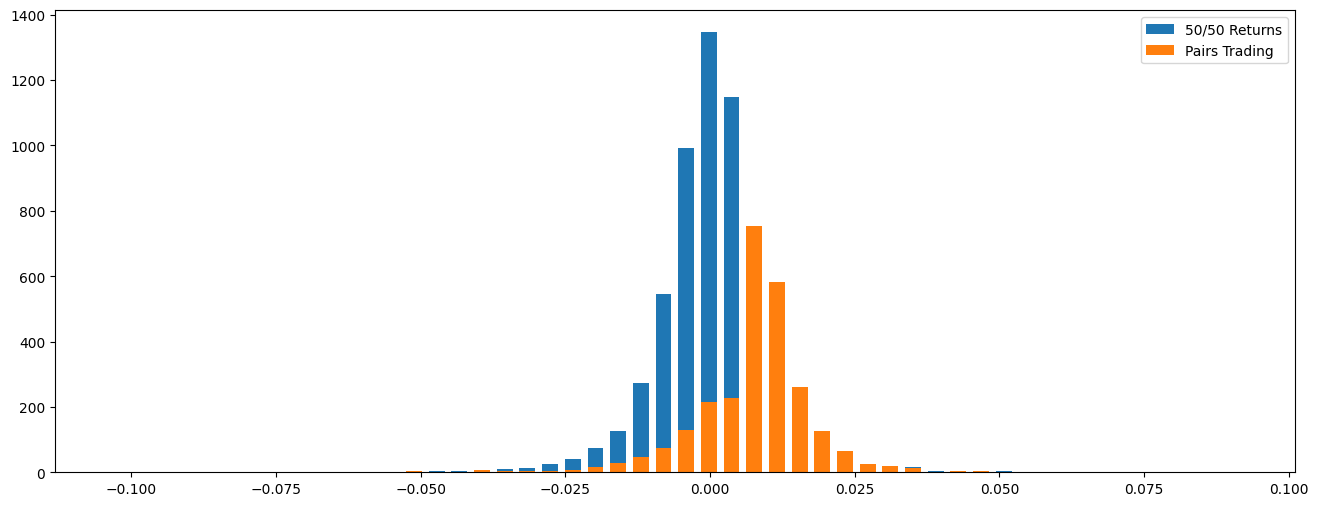

=====Strategy Returns=====
Mean return = 0.13 %
Standard deviaton = 1.35 %
Worst return = -14.41 %
Best return = 11.08 %
Lower quantile = -0.38 %
Median return = 0.26 %
Upper quantile = 0.74 %


In [7]:
returns = pairs['Returns'].dropna()
cumulret = pairs['CumulativeReturn'].dropna()

fig, ax = plt.subplots(figsize=(16,6))

hist1, bins1 = np.histogram(ReturnBoth.dropna(), bins=50)
width = 0.7 * (bins1[1] - bins1[0])
center = (bins1[:-1] + bins1[1:]) / 2

ax.bar(center, hist1, align='center', width=width, label='50/50 Returns')

hist2, bins2 = np.histogram(returns, bins=50)
ax.bar(center, hist2, align='center', width=width, label='Pairs Trading')

plt.legend()
plt.show()

print('=====Strategy Returns=====')
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("==========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [8]:
# Some stats, this could be improved by trying to estimate a yearly sharpe, among many others
executionrate = len(returns)/len(ReturnBoth)

maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1) 
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/2713750588.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/2713750588.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tret = round((float(cumulret[-1:]))*100,2)


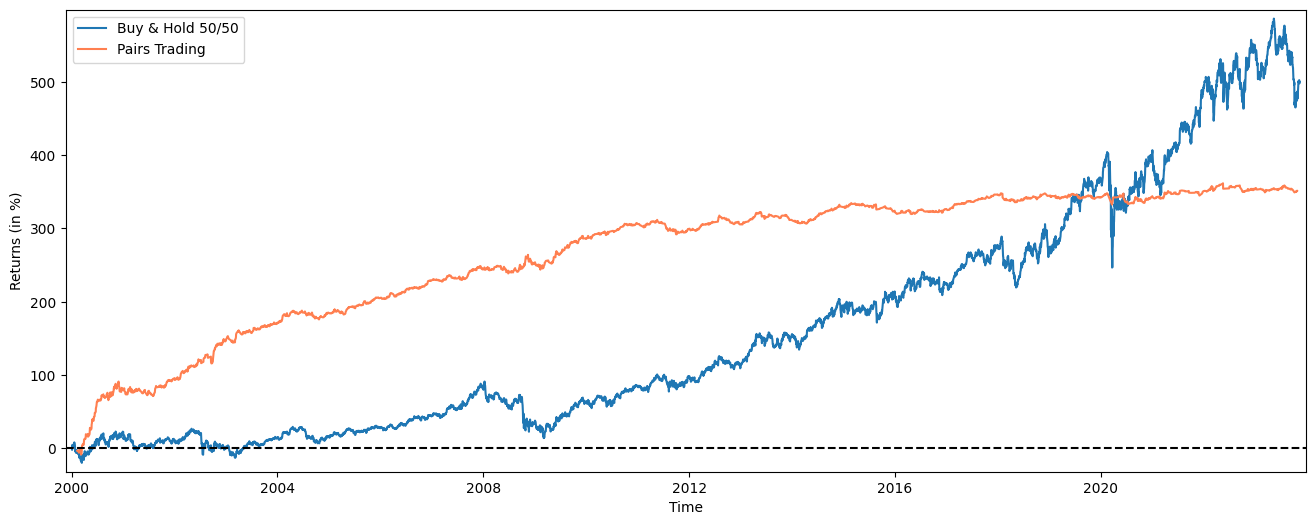

Cumulative Return =  351.26 %
Execution Rate =  43.65 %
Win Rate =  67.82 %
Maximum Loss =  20.13 %
Maximum Consecutive Loss =  15.49 %
Beta =  0.64
Sharpe =  3.88


In [9]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50')
plt.plot(cumulret*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",round(executionrate*100,2),"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)

/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/696623831.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  BuyHoldBothYTD = (((PEP['Close'][-252:]/float(PEP['Close'][-252])-1)+(KO['Close'][-252:]/float(KO['Close'][-252])-1))/2).fillna(method='ffill')
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/696623831.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  BuyHoldBothYTD = (((PEP['Close'][-252:]/float(PEP['Close'][-252])-1)+(KO['Close'][-252:]/float(KO['Close'][-252])-1))/2).fillna(method='ffill')


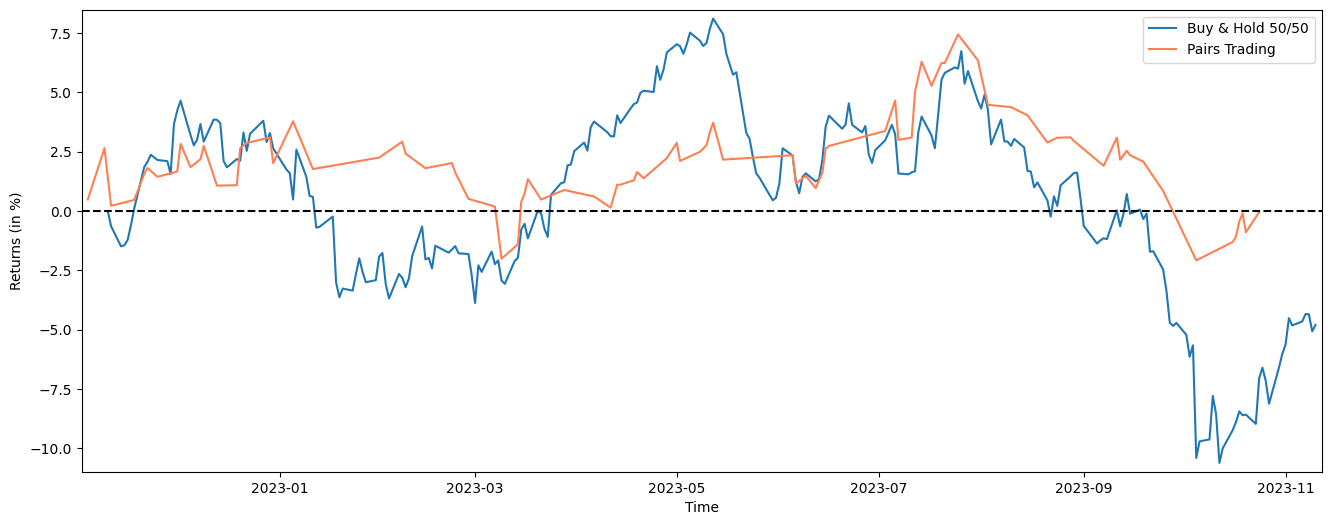

Buy & Hold 50/50 YTD Performance (at 1 July 2020) = -4.8 %
Strategy YTD Performance = -0.1 %


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/696623831.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_24532/696623831.py:15: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')


In [11]:
BuyHoldBothYTD = (((PEP['Close'][-252:]/float(PEP['Close'][-252])-1)+(KO['Close'][-252:]/float(KO['Close'][-252])-1))/2).fillna(method='ffill')
StrategyYTD = returns[-92:].cumsum()

plt.figure(figsize=(16,6))
plt.plot(BuyHoldBothYTD*100, label='Buy & Hold 50/50')
plt.plot(StrategyYTD*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()

print('Buy & Hold 50/50 YTD Performance (at 1 July 2020) =',round(float(BuyHoldBothYTD[-1:]*100),1),'%')
print('Strategy YTD Performance =',round(float(StrategyYTD[-1:]*100),1),'%')